In [82]:
from enum import Enum

import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display

# Regression

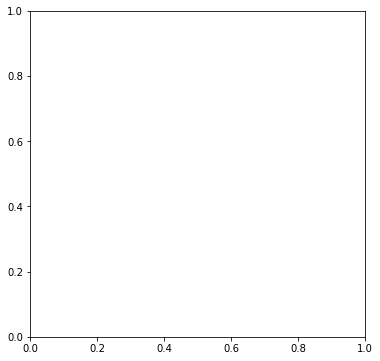

,label,type,max_set_size_mean,test_balanced_accuracy_mean,test_f1_weighted_mean,test_precision_mean,test_recall_mean
0,contains_even,deepsets_mlp_sum,8,0.541613,0.542366,0.553754,0.5546
0,contains_even,deepsets_mlp_fspool,8,0.542863,0.550469,0.551415,0.5514
0,contains_even,mlp,8,0.526883,0.535084,0.538856,0.5546
0,contains_even,sorted_mlp,8,0.530762,0.536629,0.544227,0.5536
0,contains_even,small_set_transformer,8,0.534604,0.538652,0.550022,0.5636
...,...,...,...,...,...,...,...
7,mode,deepsets_mlp_fspool,1024,0.004422,0.000363,0.000194,0.0050
7,mode,mlp,1024,0.003874,0.001807,0.001654,0.0030
7,mode,sorted_mlp,1024,0.003196,0.001397,0.001532,0.0036
7,mode,small_set_transformer,1024,0.014150,0.006881,0.009284,0.0154


test_balanced_accuracy_mean  \
label         type                                                 
contains_even deepsets_mlp_fspool                       0.507532   
              deepsets_mlp_sum                          0.508258   
              mlp                                       0.507781   
              pna                                       0.508523   
              small_set_transformer                     0.685914   
              sorted_mlp                                0.508457   
mode          deepsets_mlp_fspool                       0.031424   
              deepsets_mlp_sum                          0.015724   
              mlp                                       0.007329   
              pna                                       0.019290   
              small_set_transformer                     0.045455   
              sorted_mlp                                0.016745   

                                     test_f1_weighted_mean  \
label         type                                           
contains_even deepsets_mlp_fspool                 0.435022   
              deepsets_mlp_sum                    0.419462   
              mlp                                 0.505995   
              pna                                 0.453531   
              small_set_transformer               0.665342   
              sorted_mlp                          0.464815   
mode          deepsets_mlp_fspool                 0.023808   
              deepsets_mlp_sum                    0.008064   
              mlp                                 0.005081   
              pna                                 0.013090   
              small_set_transformer               0.034278   
              sorted_mlp                          0.010529   

                                     test_precision_mean  test_recall_mean  
label         type                                                          
contains_even deepsets_mlp_fspool               0.443456          0.513050  
              deepsets_mlp_sum                  0.414909          0.513275  
              mlp                               0.510309          0.513725  
              pna                               0.506870          0.516250  
              small_set_transformer             0.740502          0.695725  
              sorted_mlp                        0.500721          0.513975  
mode          deepsets_mlp_fspool               0.031064          0.032025  
              deepsets_mlp_sum                  0.007574          0.016375  
              mlp                               0.008348          0.006475  
              pna                               0.015677          0.020850  
              small_set_transformer             0.048348          0.044975  
              sorted_mlp                        0.012935          0.015800

In [84]:
class OutputFiles:
    regression_no_average = "regression-overview.csv"
    regession_set_size_average = "regression-overview-averaged.csv"
    classification_no_average = "classification-overview.csv"
    classification_set_size_average = "classification-overview-averaged.csv"

class TaskType(Enum):
    REGRESSION = 0
    CLASSIFICATION = 1

class ModelType(Enum):
    DEEPSETS_MLP_SUM = "deepsets_mlp_sum"
    DEEPSETS_MLP_FSPOOL = "deepsets_mlp_fspool"
    MLP = "mlp"
    SORTED_MLP = "sorted_mlp"
    SMALL_SET_TRANSFORMER = "small_set_transformer"
    PNA = "pna"

class RegressionTasks(Enum):
    SUM = "sum"
    LARGEST_PAIR_SUM = "largest_pair_sum"
    LARGEST_TRIPLE_SUM = "largest_triple_sum"
    LONGEST_SEQ_LENGTH = "longest_seq_length"
    LARGEST_CONTIGUOUS_SUM = "largest_contiguous_sum"
    MAX = "max"
    CARDINALITY = "cardinality"

class ClassificationTasks(Enum):
    CONTAINS_EVEN = "contains_even"
    MODE = "mode"

def load_regression_results() -> pd.DataFrame:
    part_1_results = pd.read_csv("regression-no-entropy.csv")
    part_2_results = pd.read_csv("regression-entropy.csv")
    part_2_results = part_2_results.drop(
        ["train_label_entropy", "valid_label_entropy", "test_label_entropy"],
        axis=1,
    )

    return pd.concat([part_1_results, part_2_results])

def load_classification_results() -> pd.DataFrame:
    return pd.read_csv("classification.csv")

def compute_task_results(results: pd.DataFrame, task: Task) -> pd.DataFrame:
    mean_results = results[results["label"] == task.value].groupby("max_set_size", as_index=False).mean()
    mean_results = mean_results.rename(
        columns={col: f"{col}_mean" for col in mean_results.columns}
    )
    std_results = results[results["label"] == task.value].groupby("max_set_size").std()
    std_results = std_results.rename(
        columns={col: f"{col}_std" for col in std_results.columns}
    )
    return mean_results

def compute_regression_model_results(results: pd.DataFrame, model_type: ModelType) -> pd.DataFrame:
    task_results = []
    for task in RegressionTasks:
        tmp_results = compute_task_results(
            results[results["type"] == model_type.value],
            task
        )
        tmp_columns = tmp_results.columns.copy()
        tmp_results["label"] = task.value
        task_results.append(tmp_results[["label", *tmp_columns]])
    return pd.concat(task_results)

def compute_classification_model_results(results: pd.DataFrame, model_type: ModelType) -> pd.DataFrame:
    task_results = []
    for task in ClassificationTasks:
        tmp_results = compute_task_results(
            results[results["type"] == model_type.value],
            task
        )
        tmp_columns = tmp_results.columns.copy()
        tmp_results["label"] = task.value
        task_results.append(tmp_results[["label", *tmp_columns]])
    return pd.concat(task_results)

def compute_classification_results_table(results: pd.DataFrame) -> pd.DataFrame:
    filtered_results = results[
        [
            "type",
            "n_params",
            "max_set_size",
            "label",
            "test_label_mean",
            "test_label_std",
            "epochs",
            "random_seed",
            "test_accuracy",
            "test_balanced_accuracy",
            "test_f1_weighted",
            "test_precision",
            "test_recall",
        ]
    ]
    model_results = []
    for model_type in ModelType:
        tmp_results = compute_classification_model_results(filtered_results, model_type)
        tmp_columns = tmp_results.columns.copy()
        tmp_results["type"] = model_type.value
        model_results.append(tmp_results[["type", *tmp_columns]])
    return pd.concat(model_results)

def compute_regression_results_table(results: pd.DataFrame) -> pd.DataFrame:
    filtered_results = results[
        [
            "type",
            "n_params",
            "max_set_size",
            "label",
            "test_label_mean",
            "test_label_std",
            "epochs",
            "random_seed",
            "test_mse",
            "test_mae",
            "test_med_ae",
            "test_max_error",
            "test_r2",
        ]
    ]
    model_results = []
    for model_type in ModelType:
        tmp_results = compute_regression_model_results(filtered_results, model_type)
        tmp_columns = tmp_results.columns.copy()
        tmp_results["type"] = model_type.value
        model_results.append(tmp_results[["type", *tmp_columns]])
    return pd.concat(model_results)

def compute_results_table(kind: TaskType) -> None:
    if kind == TaskType.REGRESSION:
        results = load_regression_results()
        results = compute_regression_results_table(results)
        results = results[
            [
                "label",
                "type",
                "max_set_size_mean",
                "test_mae_mean",
                "test_max_error_mean",
                "test_r2_mean",
            ]
        ]
        results = results.sort_values(by=["max_set_size_mean", "label"], axis="index")
        results.to_csv(OutputFiles.regression_no_average, index=None)

        overall_averaged_results = results.groupby(["label", "type"]).mean()
        overall_averaged_results.drop(["max_set_size_mean"], axis=1, inplace=True)
        overall_averaged_results.to_csv(OutputFiles.regession_set_size_average)

        display(results)
        display(overall_averaged_results)


    elif kind == TaskType.CLASSIFICATION:
        results = load_classification_results()
        results = compute_classification_results_table(results)
        results = results[
            [
                "label",
                "type",
                "max_set_size_mean",
                "test_balanced_accuracy_mean",
                "test_f1_weighted_mean",
                "test_precision_mean",
                "test_recall_mean",
            ]
        ]
        results = results.sort_values(by=["max_set_size_mean", "label"], axis="index")
        results.to_csv(OutputFiles.classification_no_average, index=None)

        overall_averaged_results = results.groupby(["label", "type"]).mean()
        overall_averaged_results.drop(["max_set_size_mean"], axis=1, inplace=True)
        overall_averaged_results.to_csv(OutputFiles.classification_set_size_average)

        display(results)
        display(overall_averaged_results)
    else:
        raise ValueError(f"Unknown task type: {kind}")

compute_results_table(TaskType.REGRESSION)
compute_results_table(TaskType.CLASSIFICATION)